# PytorchでFast style transfar

In [1]:
#transformer.py
import torch
import torch.nn as nn
import torchvision.models as models
class TransformerNetwork(nn.Module):
    def __init__(self):
        super(TransformerNetwork, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3)
        )
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None")
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out

class TransformerNetworkTanh(TransformerNetwork):

    # override __init__ method
    def __init__(self, tanh_multiplier=150):
        super(TransformerNetworkTanh, self).__init__()
        # Add a Tanh layer before output
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None"),
            nn.Tanh()
        )
        self.tanh_multiplier = tanh_multiplier

    # Override forward method
    def forward(self, x):
        return super(TransformerNetworkTanh, self).forward(x) * self.tanh_multiplier

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="instance"):
        super(ConvLayer, self).__init__()
        # Padding Layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Convolution Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    """
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, channels=128, kernel_size=3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)

    def forward(self, x):
        identity = x                     # preserve residual
        out = self.relu(self.conv1(x))   # 1st conv layer + activation
        out = self.conv2(out)            # 2nd conv layer
        out = out + identity             # add residual
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution 
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

In [2]:
#utils.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets

# Gram Matrix
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(B, C, H*W)
    x_t = x.transpose(1, 2)
    return  torch.bmm(x, x_t) / (C*H*W)

# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

def saveimg(img, image_path):
    img = img.clip(0, 255)
    cv2.imwrite(image_path, img)

# Preprocessing ~ Image to Tensor
def itot(img, max_size=None):
    # Rescale the image
    if (max_size==None):
        itot_t = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])    
    else:
        H, W, C = img.shape
        image_size = tuple([int((float(max_size) / max([H,W]))*x) for x in [H, W]])
        itot_t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])

    # Convert image to tensor
    tensor = itot_t(img)

    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

# Preprocessing ~ Tensor to Image
def ttoi(tensor):
    # Add the means
    #ttoi_t = transforms.Compose([
    #    transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    #img = ttoi_t(tensor)
    img = tensor.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

def transfer_color(src, dest):

    src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR).clip(0,255)  #4 Convert new image from YIQ back to BGR

def plot_loss_hist(c_loss, s_loss, total_loss, title="Loss History"):
    x = [i for i in range(len(total_loss))]
    plt.figure(figsize=[10, 6])
    plt.plot(x, c_loss, label="Content Loss")
    plt.plot(x, s_loss, label="Style Loss")
    plt.plot(x, total_loss, label="Total Loss")
    
    plt.legend()
    plt.xlabel('Every 500 iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

class ImageFolderWithPaths(datasets.ImageFolder):

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)

        # the image file path
        path = self.imgs[index][0]

        # make a new tuple that includes original and the path
        tuple_with_path = (*original_tuple, path)
        return tuple_with_path

# Fast style transfarの学習

In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms


class VGG19(nn.Module):
    def __init__(self, vgg_path="models/vgg19-d01eb7cb.pth"):
        super(VGG19, self).__init__()
        # Load VGG Skeleton, Pretrained Weights
        vgg19_features = models.vgg19(pretrained=False)
        vgg19_features.load_state_dict(torch.load(vgg_path), strict=False)
        self.features = vgg19_features.features

        # Turn-off Gradient History
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '17': 'relu3_4', '22': 'relu4_2', '26': 'relu4_4', '35': 'relu5_4'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x

        return features

class VGG16(nn.Module):
    def __init__(self, vgg_path="vgg16-00b39a1b.pth"):
        super(VGG16, self).__init__()
        # Load VGG Skeleton, Pretrained Weights
        vgg16_features = models.vgg16(pretrained=False)
        vgg16_features.load_state_dict(torch.load(vgg_path), strict=False)
        self.features = vgg16_features.features

        # Turn-off Gradient History
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                if (name=='22'):
                    break

        return features

========Epoch 1/20========
========Iteration 1/1280========
	Content Loss:	2114261.00
	Style Loss:	21087266.00
	Total Loss:	23201528.00
Time elapsed:	1.0356733798980713 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_0.pth
Saved sample tranformed image at images/sample0_0.png
========Epoch 2/20========
========Epoch 3/20========
========Epoch 4/20========
========Epoch 5/20========
========Epoch 6/20========
========Epoch 7/20========
========Epoch 8/20========
========Iteration 501/1280========
	Content Loss:	1448863.25
	Style Loss:	3073207.77
	Total Loss:	4522070.45
Time elapsed:	163.60938501358032 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_500.pth
Saved sample tranformed image at images/sample0_500.png
========Epoch 9/20========
========Epoch 10/20========
========Epoch 11/20========
========Epoch 12/20========
========Epoch 13/20========
========Epoch 14/20========
========Epoch 15/20========
========Epoch 16/20========
========Itera

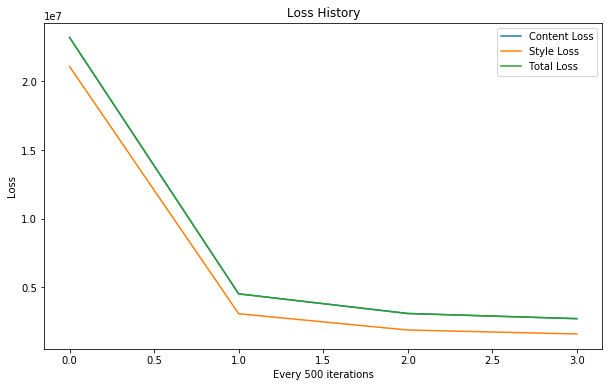

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import time



# GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "dataset/train/"
NUM_EPOCHS = 20
STYLE_IMAGE_PATH = "pika.jpg"
BATCH_SIZE =4
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "models/"
SAVE_IMAGE_PATH = "images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    TransNet = TransformerNetwork().to(device)
    VGG = VGG16().to(device)

    # Get Style Features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    style_image = load_image(STYLE_IMAGE_PATH)
    style_tensor = itot(style_image).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    B, C, H, W = style_tensor.shape
    style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = gram(value)

    # Optimizer settings
    optimizer = optim.Adam(TransNet.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # Free-up unneeded cuda memory
            torch.cuda.empty_cache()

            # Zero-out Gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = TransNet(content_batch)
            content_features = VGG(content_batch.add(imagenet_neg_mean))
            generated_features = VGG(generated_batch.add(imagenet_neg_mean))

            # Content Loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Style Loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backprop and Weight Update
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(TransNet.state_dict(), checkpoint_path)
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                saveimg(sample_image, sample_image_path)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)

            # Iterate Batch Counter
            batch_count+=1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    TransNet.eval()
    TransNet.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(TransNet.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)

train()

Stylize Image~ Press Ctrl+C and Enter to close the program
Enter the image path: b.jpg
Transfer Time: 0.15873074531555176


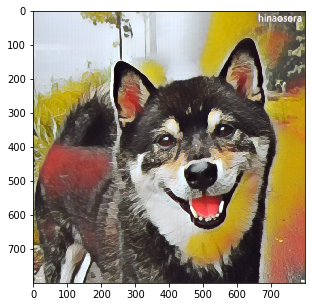

In [8]:
import torch
# import utils
# import transformer
import os
from torchvision import transforms
import time
import cv2

STYLE_TRANSFORM_PATH = "models/checkpoint_1279.pth"
PRESERVE_COLOR = False

def stylize():
    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Load Transformer Network
    net = TransformerNetwork()
    net.load_state_dict(torch.load(STYLE_TRANSFORM_PATH))
    net = net.to(device)

    with torch.no_grad():
            torch.cuda.empty_cache()
            print("Stylize Image~ Press Ctrl+C and Enter to close the program")
            content_image_path = input("Enter the image path: ")
            content_image = load_image(content_image_path)
            starttime = time.time()
            content_tensor = itot(content_image).to(device)
            generated_tensor = net(content_tensor)
            generated_image = ttoi(generated_tensor.detach())
            if (PRESERVE_COLOR):
                generated_image = transfer_color(content_image, generated_image)
            print("Transfer Time: {}".format(time.time() - starttime))
            show(generated_image)
           
def stylize_folder_single(style_path, content_folder, save_folder):

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Load Transformer Network
    net = TransformerNetwork()
    net.load_state_dict(torch.load(style_path))
    net = net.to(device)

    # Stylize every frame
    images = [img for img in os.listdir(content_folder) if img.endswith(".jpg")]
    with torch.no_grad():
        for image_name in images:
            # Free-up unneeded cuda memory
            torch.cuda.empty_cache()
            
            # Load content image
            content_image = load_image(content_folder + image_name)
            content_tensor = itot(content_image).to(device)

            # Generate image
            generated_tensor = net(content_tensor)
            generated_image = ttoi(generated_tensor.detach())
            if (PRESERVE_COLOR):
                generated_image = transfer_color(content_image, generated_image)
            # Save image
            saveimg(generated_image, save_folder + image_name)

def stylize_folder(style_path, folder_containing_the_content_folder, save_folder, batch_size=1):

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Image loader
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    image_dataset = ImageFolderWithPaths(folder_containing_the_content_folder, transform=transform)
    image_loader = torch.data.DataLoader(image_dataset, batch_size=batch_size)

    # Load Transformer Network
    net = TransformerNetwork()
    net.load_state_dict(torch.load(style_path))
    net = net.to(device)

    # Stylize batches of images
    with torch.no_grad():
        for content_batch, _, path in image_loader:
            # Free-up unneeded cuda memory
            torch.cuda.empty_cache()

            # Generate image
            generated_tensor = net(content_batch.to(device)).detach()

            # Save images
            for i in range(len(path)):
                generated_image = ttoi(generated_tensor[i])
                if (PRESERVE_COLOR):
                    generated_image = transfer_color(content_image, generated_image)
                image_name = os.path.basename(path[i])
                saveimg(generated_image, save_folder + image_name)

stylize()

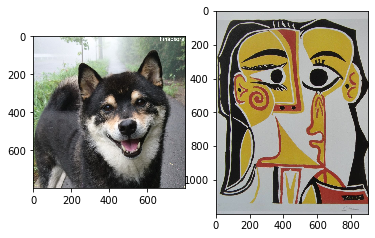

In [9]:
img = cv2.imread('b.jpg')
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im_rgb)
img2 = cv2.imread('pika.jpg')
im_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(im_rgb2)

# 考察
変換速度が1秒と高速になっていた。あらかじめにパラメータの学習を決めたスタイルと多くの画像で行い、その重みを使い画像を変換していることによるものであると考えられる。BatchNormalizationの代わりにInstance Normalizationを畳み込み層とDeconv層の後に使用することによってスタイルの構造を崩すことなく変換できるらしい。変換後の結果を見ても犬を認識したうえでの変換を行っているように見えた。